## Preprocess Moorings DITx

In [65]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import gsw
import pandas
import glob 

### Some useful functions 

In [66]:
def U_V_from_Dir_Speed(dir,speed):
    """
    Calculate u and v velocity components from speed and direction data
    """
    # get direction in radians 
    direction_rad = np.deg2rad(dir)

    # get U and V components using trig functions 

    U = speed * np.cos(direction_rad)  # x-component
    V = speed * np.sin(direction_rad) 

    return U, V

# def Add_U_V_if_missing(ds):
#     """ 
#     """
#     if 'u' and 'v' in ds.data_vars:
#         pass
#     elif 'temp' in ds.data_vars:
#         pass
#     elif 'temp' and 'dir' in ds.data_vars:
#         u,v = U_V_from_Dir_Speed(ds.dir,ds.speed)
#         ds['u'] = ('time', u.data)
#         ds['v'] = ('time', v.data)
#     else:
#         u,v = U_V_from_Dir_Speed(ds.dir,ds.speed)
#         ds['u'] = ('time', u.data)
#         ds['v'] = ('time', v.data)

#     return ds

def Add_U_V_if_missing(ds):
    """
    Add u and v velocity components if:
      - u and v do not already exist
      - dir and speed exist

    Skip datasets with only temperature or insufficient variables.
    """

    vars_present = set(ds.data_vars)

    # Case 1: Already has u and v → do nothing
    if {'u', 'v'}.issubset(vars_present):
        return ds

    # Case 2: Has dir and speed → compute u, v
    if {'dir', 'speed'}.issubset(vars_present):
        u, v = U_V_from_Dir_Speed(ds.dir, ds.speed)

        ds = ds.assign(
            u=u.rename('u'),
            v=v.rename('v')
        )

        return ds

    # Case 3: Everything else (e.g., temp-only datasets) → skip
    return ds




In [67]:
# Create function for renaming dimensions 

def rename_vars_if_exist(ds, rename_map):
    """
    Rename variables in an xarray Dataset only if they exist.

    Parameters
    ----------
    ds : xr.Dataset
        Input dataset
    rename_map : dict
        Mapping {old_name: new_name}

    Returns
    -------
    xr.Dataset
        Dataset with variables renamed where applicable
    """
    existing = {old: new for old, new in rename_map.items() if old in ds.data_vars}
    return ds.rename(existing)


In [68]:
rename_map = {
    "T": "temp",
    "dirt": "dir",
    "spe": "speed",
    "dep": "depth",
    "P": "pres",
    "S": "sal",
    "sig_t": "sigma0"
    
}

In [69]:
# add in attributes 
# define matadata for coorindates and variables - this will be the same for top and bottom sensor 
META_DATA = {
    "pres": {
        "long_name": "Pressure",
        "units": "dbar",
    },
    "abs_sal": {
        "long_name": "Absolute Salinity",
        "units": "g/kg",
    },
    "cons_temp": {
        "long_name": "Conservative Temperature",
        "units": "degree_Celsius",
    },
    "cons_temp_freezing": {
        "long_name": "Conservative Temperature Freezing",
        "units": "degree_Celsius",
    },
    "sigma0": {
        "long_name": "Potential Density Anomaly",
        "units": "kg/m3",
    },
    "theta": {
        "long_name": "Potential Temperature",
        "units": "degree_Celsius",
    },
    "sal": {
        "long_name": "Practical salinity",
        "units": "PSU",
    },
    "temp_freezing": {
        "long_name": "Temperature Freezing [ITS-90 deg C]",
        "units": "degree_Celsius",
    },
    "temp": {
        "long_name": "Temperature [ITS-90 deg C]",
        "units": "degree_Celsius",
    },
    "con": {
        "long_name": "Conductivity",
        "units": "S/m",
    },
    "z": {
        "long_name": "Depth",
        "units": "m",
        "description": "Depth is positive downward"
    },
    "lat": {
        "long_name": "Latitude",
        "units": "degrees_north",
    },
    "lon": {
        "long_name": "Longitude",
        "units": "degrees_east",
    },
    "u":{
        "long_name": "Eastward Velocity",
        "units": "cm/s",
    },
    "v":{
        "long_name": "Northward Velocity",
        "units": "cm/s",
    },
    "w": {
        "long_name": "Vertical Velocity",
        "units": "m/s",
    },
    "speed": {
        "long_name": "speed",
        "units": "cm/s",
    },
    "dir": {
        "long_name": "direction",
        "units": "degrees",
    },
    "mag_declination": {
        "long_name": "Magnetic Declination",
        "units": "degrees East",
        "description": "Angle between magnetic North and true North"
    },
    
    
}

### Load and Format DITS 

In [70]:
# load in all datasets for DITD mooring 
paths = glob.glob("//thepenguin/penguin2/Data/TNB/mooring/DITx/DITS/raw/*.nc")

In [71]:
paths

['//thepenguin/penguin2/Data/TNB/mooring/DITx/DITS/raw\\121644.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITS/raw\\121645.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITS/raw\\121646.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITS/raw\\121647.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITS/raw\\121648.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITS/raw\\121649.nc']

In [72]:
# create a list to hold datasets 
ds_list = []
for path in paths:
    ds = xr.open_dataset(path)
    ds_list.append(ds)

In [73]:
for i in range(len(ds_list)):
    print(ds_list[i].attrs['description'] + ', depth= ' + ds_list[i].z.values.astype(str))
# print(ds_list[1].attrs['description'] + ', depth= ' + ds_list[1].z.values.astype(str))

['Mooring DITS 1702 rcm9, depth= 191' 'Mooring DITS 1702 rcm9, depth= 384'
 'Mooring DITS 1702 rcm9, depth= 1087']
['Mooring DITS 1702 SBE37SM, depth= 192'
 'Mooring DITS 1702 SBE37SM, depth= 383'
 'Mooring DITS 1702 SBE37SM, depth= 1088']
['Mooring DITS 1702 SBE56, depth= 233'
 'Mooring DITS 1702 SBE56, depth= 273'
 'Mooring DITS 1702 SBE56, depth= 313'
 'Mooring DITS 1702 SBE56, depth= 353']
['Mooring DITS 1803 AQD, depth= 47' 'Mooring DITS 1803 AQD, depth= 220'
 'Mooring DITS 1803 AQD, depth= 1027']
['Mooring DITS 1803 SBE37SM, depth= 63'
 'Mooring DITS 1803 SBE37SM, depth= 208'
 'Mooring DITS 1803 SBE37SM, depth= 1458']
['Mooring DITS 1803 SBE56, depth= 88'
 'Mooring DITS 1803 SBE56, depth= 128'
 'Mooring DITS 1803 SBE56, depth= 168'
 'Mooring DITS 1803 SBE56, depth= 208']


In [74]:
# assemble datasets based on year, instrument, position 
DITS_2017_speed_top = ds_list[0].sel(z=191).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})
DITS_2017_speed_mid = ds_list[0].sel(z=384).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})
DITS_2017_speed_bot = ds_list[0].sel(z=1087).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})

DITS_2017_ctd_top = ds_list[1].sel(z=192).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})
DITS_2017_ctd_mid = ds_list[1].sel(z=383).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})
DITS_2017_ctd_bot = ds_list[1].sel(z=1088).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})

DITS_2017_temp_top = ds_list[2].sel(z=233).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})
DITS_2017_temp_mid1 = ds_list[2].sel(z=273).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})
DITS_2017_temp_mid2 = ds_list[2].sel(z=313).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})
DITS_2017_temp_bot = ds_list[2].sel(z=353).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4884,'lon':163.1744})

DITS_2018_vel_top = ds_list[3].sel(z=47).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})
DITS_2018_vel_mid = ds_list[3].sel(z=220).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})
DITS_2018_vel_bot = ds_list[3].sel(z=1027).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})

DITS_2018_ctd_top = ds_list[4].sel(z=63).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})
DITS_2018_ctd_mid = ds_list[4].sel(z=208).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})
DITS_2018_ctd_bot = ds_list[4].sel(z=1458).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})

DITS_2018_temp_top = ds_list[5].sel(z=88).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})
DITS_2018_temp_mid1 = ds_list[5].sel(z=128).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})
DITS_2018_temp_mid2 = ds_list[5].sel(z=168).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})
DITS_2018_temp_bot = ds_list[5].sel(z=208).rename({'DateTime':'time'}).squeeze().assign_coords({'lat':-75.4886,'lon':163.2042})


In [75]:
# create list of datasets and names
DITS_datasets = [
    DITS_2017_speed_top,
    DITS_2017_speed_mid,
    DITS_2017_speed_bot,
    DITS_2017_ctd_top,
    DITS_2017_ctd_mid,
    DITS_2017_ctd_bot,
    DITS_2017_temp_top,
    DITS_2017_temp_mid1,
    DITS_2017_temp_mid2,
    DITS_2017_temp_bot,
    DITS_2018_vel_top,
    DITS_2018_vel_mid,
    DITS_2018_vel_bot,
    DITS_2018_ctd_top,
    DITS_2018_ctd_mid,
    DITS_2018_ctd_bot,
    DITS_2018_temp_top,
    DITS_2018_temp_mid1,
    DITS_2018_temp_mid2,
    DITS_2018_temp_bot,
]

dataset_names = [
    'DITS_2017_speed_top_191',
    'DITS_2017_speed_mid_384',
    'DITS_2017_speed_bot_1087',
    'DITS_2017_ctd_top_192',
    'DITS_2017_ctd_mid_383',
    'DITS_2017_ctd_bot_1088',
    'DITS_2017_temp_top_233',
    'DITS_2017_temp_mid1_273',
    'DITS_2017_temp_mid2_313',
    'DITS_2017_temp_bot_353',
    'DITS_2018_vel_top_47',
    'DITS_2018_vel_mid_220',
    'DITS_2018_vel_bot_1027',
    'DITS_2018_ctd_top_63',
    'DITS_2018_ctd_mid_208',
    'DITS_2018_ctd_bot_1458',
    'DITS_2018_temp_top_88',
    'DITS_2018_temp_mid1_128',
    'DITS_2018_temp_mid2_168',
    'DITS_2018_temp_bot_208',
]

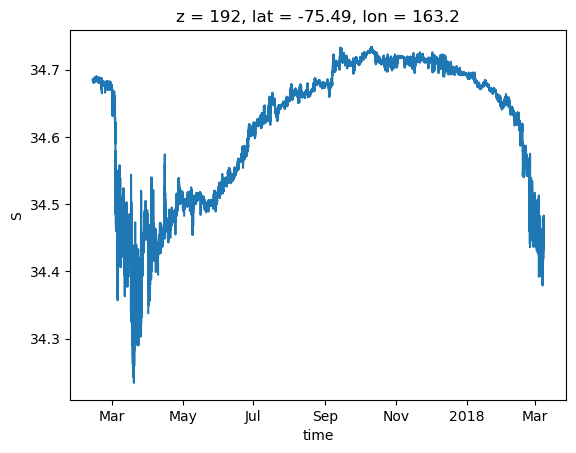

In [ ]:
DITS_2017_ctd_.S.plot()

In [14]:
for i in range(len(DITS_datasets)):
    DITS_datasets[i] = rename_vars_if_exist(DITS_datasets[i], rename_map)
    DITS_datasets[i] = Add_U_V_if_missing(DITS_datasets[i])

In [15]:
for v, attrs in META_DATA.items():
    for i in range(len(DITS_datasets)):
        if v in DITS_datasets[i]:
            DITS_datasets[i][v].attrs.update(attrs)

In [18]:
DITS_datasets[0]

<xarray.Dataset> Size: 374kB
Dimensions:  (time: 9338)
Coordinates:
  * time     (time) datetime64[ns] 75kB 2017-02-12T13:00:00 ... 2018-03-08T14...
    z        int64 8B 191
    lat      float64 8B -75.49
    lon      float64 8B 163.2
Data variables:
    dir      (time) float64 75kB 339.0 5.0 356.0 11.0 ... 123.0 130.0 93.0 136.0
    speed    (time) float64 75kB ...
    u        (time) float64 75kB 5.508 4.084 4.689 ... -1.478 -0.1675 -1.654
    v        (time) float64 75kB -2.114 0.3573 -0.3279 ... 1.762 3.196 1.598
Attributes:
    description:  Mooring DITS 1702 rcm9

In [19]:
for i in range(len(DITS_datasets)):
    DITS_datasets[i].to_netcdf(path='//thepenguin/penguin2/Data/TNB/mooring/DITx/DITS/working/'+dataset_names[i]+'.nc')

In [ ]:
# save final datasets 
# final_datasets = [P3_2018_speed_bot_1693,P3_2018_ctd_bot_1667,P3_2018_ctd_mid_1414,P3_2018_ctd_top_1262,
#                 P3_2018_temp_mid_1498, P3_2018_vel_top_1263]

# final_names = ['P3_2018_speed_bot_1693','P3_2018_ctd_bot_1667','P3_2018_ctd_mid_1414','P3_2018_ctd_top_1262',
#                 'P3_2018_temp_mid_1498', 'P3_2018_vel_top_1263']

# for i in range(len(final_datasets)):
#     final_datasets[i].to_netcdf(path='//thepenguin/penguin2/Data/TNB/mooring/RossSeaOutflow/P3/'+final_names[i]+'.nc')

c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


Text(0.5, 1.0, 'Deep (1087 m)')

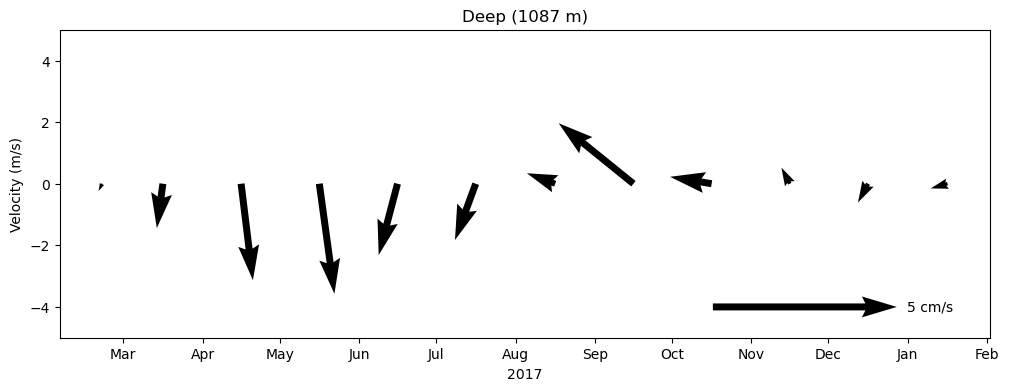

In [235]:
ds = DITS_datasets[2]
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12,4))
q = plt.quiver(
    ds.time.sel(time=slice('2017-02','2018-01')).resample(time='1M').mean().values,np.zeros_like(ds.time.sel(time=slice('2017-02','2018-01')).resample(time='1M').mean().values, dtype=float),
    ds.u.sel(time=slice('2017-02','2018-01')).resample(time='1M').mean(),
    ds.v.sel(time=slice('2017-02','2018-01')).resample(time='1M').mean()
)
plt.quiverkey(q, X=0.90, Y=0.1, U=5, label='5 cm/s', labelpos='E')

plt.ylabel('Velocity (m/s)')
plt.ylim(-5,5)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Show year once at the left
ax.set_xlabel('2017')
ax.set_title('Deep (1087 m)')


Monthly mean currents for DITS do not match well with what has been published in Stevens et al. 2024. Need to check about this with Liv 

### DITN

In [53]:
# load in all datasets for DITD mooring 
paths = glob.glob("//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN/*.nc")

In [54]:
paths

['//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121625.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121626.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121627.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121628.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121629.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121630.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121631.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121632.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121633.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121634.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121635.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121636.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121637.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121638.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121639.nc',
 '//thepenguin/penguin2/Data/TNB/mooring

In [55]:
# create a list to hold datasets 
ds_list = []
for path in paths:
    ds = xr.open_dataset(path)
    ds_list.append(ds)

In [56]:
for i in range(len(ds_list)):
    print(ds_list[i].attrs['description'] + ', depth= ' + ds_list[i].z.values.astype(str))
# print(ds_list[1].attrs['description'] + ', depth= ' + ds_list[1].z.values.astype(str))

['Mooring DITN 1412 rcm9, depth= 75' 'Mooring DITN 1412 rcm9, depth= 276'
 'Mooring DITN 1412 rcm9, depth= 674']
['Mooring DITN 1412 SBE37SM, depth= 77'
 'Mooring DITN 1412 SBE37SM, depth= 278'
 'Mooring DITN 1412 SBE37SM, depth= 667']
['Mooring DITN 1412 SBE56, depth= 108'
 'Mooring DITN 1412 SBE56, depth= 148'
 'Mooring DITN 1412 SBE56, depth= 188'
 'Mooring DITN 1412 SBE56, depth= 228']
['Mooring DITN 1512 SBE37SM, depth= 73'
 'Mooring DITN 1512 SBE37SM, depth= 275'
 'Mooring DITN 1512 SBE37SM, depth= 666']
['Mooring DITN 1512 rcm9, depth= 71' 'Mooring DITN 1512 rcm9, depth= 273'
 'Mooring DITN 1512 rcm9, depth= 667']
['Mooring DITN 1512 SBE56, depth= 113'
 'Mooring DITN 1512 SBE56, depth= 153'
 'Mooring DITN 1512 SBE56, depth= 193'
 'Mooring DITN 1512 SBE56, depth= 233']
['Mooring DITN 1702 AQD, depth= 76' 'Mooring DITN 1702 AQD, depth= 271'
 'Mooring DITN 1702 AQD, depth= 694']
['Mooring DITN 1702 rcm9, depth= 75' 'Mooring DITN 1702 rcm9, depth= 270'
 'Mooring DITN 1702 rcm9, dept

In [57]:
ds_list[0]

<xarray.Dataset> Size: 1MB
Dimensions:   (z: 3, DateTime: 15789)
Coordinates:
  * z         (z) int64 24B 75 276 674
  * DateTime  (DateTime) datetime64[ns] 126kB 2014-12-12T14:30:00 ... 2015-11...
Data variables:
    dirt      (z, DateTime) float64 379kB ...
    spe       (z, DateTime) float64 379kB ...
    T         (z, DateTime) float64 379kB ...
Attributes:
    description:  Mooring DITN 1412 rcm9

In [58]:
# sepearte mooring data by top, mid, bottom sensors 
DITN_2014_speed_top = ds_list[0].sel(z=75).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_speed_mid = ds_list[0].sel(z=276).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_speed_bot = ds_list[0].sel(z=674).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})

DITN_2014_ctd_top = ds_list[1].sel(z=77).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_ctd_mid = ds_list[1].sel(z=278).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_ctd_bot = ds_list[1].sel(z=667).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})

DITN_2014_temp_top = ds_list[2].sel(z=108).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_temp_mid1 = ds_list[2].sel(z=148).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_temp_mid2 = ds_list[2].sel(z=188).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_temp_bot = ds_list[2].sel(z=228).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})

DITN_2015_ctd_top = ds_list[3].sel(z=73).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_ctd_mid = ds_list[3].sel(z=275).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_ctd_bot = ds_list[3].sel(z=666).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})

DITN_2015_speed_top = ds_list[4].sel(z=71).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_speed_mid = ds_list[4].sel(z=273).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_speed_bot = ds_list[4].sel(z=667).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})

DITN_2015_temp_top = ds_list[5].sel(z=113).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_temp_mid1 = ds_list[5].sel(z=153).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_temp_mid2 = ds_list[5].sel(z=193).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_temp_bot = ds_list[5].sel(z=233).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})

DITN_2017_vel_top = ds_list[6].sel(z=76).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_vel_mid = ds_list[6].sel(z=271).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_vel_bot = ds_list[6].sel(z=694).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})

DITN_2017_speed_top = ds_list[7].sel(z=75).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_speed_mid = ds_list[7].sel(z=270).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_speed_bot = ds_list[7].sel(z=667).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})

DITN_2017_ctd_top = ds_list[8].sel(z=75).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_ctd_mid = ds_list[8].sel(z=275).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_ctd_bot = ds_list[8].sel(z=675).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})

DITN_2017_temp_top = ds_list[9].sel(z=197).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_temp_mid = ds_list[9].sel(z=330).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_temp_bot = ds_list[9].sel(z=360).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})

DITN_2018_ctd_top = ds_list[10].sel(z=73).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_ctd_mid = ds_list[10].sel(z=274).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_ctd_bot = ds_list[10].sel(z=670).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})

DITN_2018_temp_top = ds_list[11].sel(z=114).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_temp_mid1 = ds_list[11].sel(z=154).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_temp_mid2 = ds_list[11].sel(z=194).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_temp_bot = ds_list[11].sel(z=224).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})

DITN_2018_vel_top = ds_list[13].sel(z=71).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_vel_mid = ds_list[13].sel(z=263).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_vel_bot = ds_list[13].sel(z=666).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})

DITN_2019_vel_top = ds_list[12].sel(z=67).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_vel_mid = ds_list[12].sel(z=255).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_vel_bot = ds_list[12].sel(z=649).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})

DITN_2019_ctd_top = ds_list[14].sel(z=71).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_ctd_mid = ds_list[14].sel(z=271).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})

DITN_2019_temp_top = ds_list[15].sel(z=112).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_temp_mid1 = ds_list[15].sel(z=152).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_temp_mid2 = ds_list[15].sel(z=192).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_temp_bot = ds_list[15].sel(z=232).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})

DITN_2020_vel_top = ds_list[16].sel(z=54).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_vel_mid = ds_list[16].sel(z=252).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_vel_bot = ds_list[16].sel(z=671).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})

DITN_2020_ctd_mid = ds_list[17].sel(z=269).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_ctd_bot = ds_list[17].sel(z=667).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})

DITN_2020_temp_top = ds_list[18].sel(z=95).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_temp_mid1 = ds_list[18].sel(z=135).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_temp_mid2 = ds_list[18].sel(z=175).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_temp_bot = ds_list[18].sel(z=215).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})



In [59]:
# make list of datasets and names 
DITN_datasets = [
    DITN_2014_speed_top,
    DITN_2014_speed_mid,
    DITN_2014_speed_bot,
    DITN_2014_ctd_top,
    DITN_2014_ctd_mid,
    DITN_2014_ctd_bot,
    DITN_2014_temp_top,
    DITN_2014_temp_mid1,
    DITN_2014_temp_mid2,
    DITN_2014_temp_bot,
    DITN_2015_ctd_top,
    DITN_2015_ctd_mid,
    DITN_2015_ctd_bot,
    DITN_2015_speed_top,
    DITN_2015_speed_mid,
    DITN_2015_speed_bot,
    DITN_2015_temp_top,
    DITN_2015_temp_mid1,
    DITN_2015_temp_mid2,
    DITN_2015_temp_bot,
    DITN_2017_vel_top,
    DITN_2017_vel_mid,
    DITN_2017_vel_bot,
    DITN_2017_speed_top,
    DITN_2017_speed_mid,
    DITN_2017_speed_bot,
    DITN_2017_ctd_top,
    DITN_2017_ctd_mid,
    DITN_2017_ctd_bot,
    DITN_2017_temp_top,
    DITN_2017_temp_mid,
    DITN_2017_temp_bot,
    DITN_2018_ctd_top,
    DITN_2018_ctd_mid,
    DITN_2018_ctd_bot,
    DITN_2018_temp_top,
    DITN_2018_temp_mid1,
    DITN_2018_temp_mid2,
    DITN_2018_temp_bot,
    DITN_2018_vel_top,
    DITN_2018_vel_mid,
    DITN_2018_vel_bot,
    DITN_2019_vel_top,
    DITN_2019_vel_mid,
    DITN_2019_vel_bot,
    DITN_2019_ctd_top,
    DITN_2019_ctd_mid,
    DITN_2019_temp_top,
    DITN_2019_temp_mid1,
    DITN_2019_temp_mid2,
    DITN_2019_temp_bot,
    DITN_2020_vel_top,
    DITN_2020_vel_mid,
    DITN_2020_vel_bot,
    DITN_2020_ctd_mid,
    DITN_2020_ctd_bot,
    DITN_2020_temp_top,
    DITN_2020_temp_mid1,
    DITN_2020_temp_mid2,
    DITN_2020_temp_bot,
]

dataset_names = [
    'DITN_2014_speed_top_75',
    'DITN_2014_speed_mid_276',
    'DITN_2014_speed_bot_674',
    'DITN_2014_ctd_top_77',
    'DITN_2014_ctd_mid_278',
    'DITN_2014_ctd_bot_667',
    'DITN_2014_temp_top_108',
    'DITN_2014_temp_mid1_148',
    'DITN_2014_temp_mid2_188',
    'DITN_2014_temp_bot_228',
    'DITN_2015_ctd_top_73',
    'DITN_2015_ctd_mid_275',
    'DITN_2015_ctd_bot_666',
    'DITN_2015_speed_top_71',
    'DITN_2015_speed_mid_273',
    'DITN_2015_speed_bot_667',
    'DITN_2015_temp_top_113',
    'DITN_2015_temp_mid1_153',
    'DITN_2015_temp_mid2_193',
    'DITN_2015_temp_bot_233',
    'DITN_2017_vel_top_76',
    'DITN_2017_vel_mid_271',
    'DITN_2017_vel_bot_694',
    'DITN_2017_speed_top_75',
    'DITN_2017_speed_mid_270',
    'DITN_2017_speed_bot_667',
    'DITN_2017_ctd_top_75',
    'DITN_2017_ctd_mid_275',
    'DITN_2017_ctd_bot_675',
    'DITN_2017_temp_top_197',
    'DITN_2017_temp_mid_330',
    'DITN_2017_temp_bot_360',
    'DITN_2018_ctd_top_73',
    'DITN_2018_ctd_mid_274',
    'DITN_2018_ctd_bot_670',
    'DITN_2018_temp_top_114',
    'DITN_2018_temp_mid1_154',
    'DITN_2018_temp_mid2_194',
    'DITN_2018_temp_bot_224',
    'DITN_2018_vel_top_71',
    'DITN_2018_vel_mid_263',
    'DITN_2018_vel_bot_666',
    'DITN_2019_vel_top_67',
    'DITN_2019_vel_mid_255',
    'DITN_2019_vel_bot_649',
    'DITN_2019_ctd_top_71',
    'DITN_2019_ctd_mid_271',
    'DITN_2019_temp_top_112',
    'DITN_2019_temp_mid1_152',
    'DITN_2019_temp_mid2_192',
    'DITN_2019_temp_bot_232',
    'DITN_2020_vel_top_54',
    'DITN_2020_vel_mid_252',
    'DITN_2020_vel_bot_671',
    'DITN_2020_ctd_mid_269',
    'DITN_2020_ctd_bot_667',
    'DITN_2020_temp_top_95',
    'DITN_2020_temp_mid1_135',
    'DITN_2020_temp_mid2_175',
    'DITN_2020_temp_bot_215',
]


In [60]:
for i in range(len(DITN_datasets)):
    DITN_datasets[i] = rename_vars_if_exist(DITN_datasets[i], rename_map)
    DITN_datasets[i] = Add_U_V_if_missing(DITN_datasets[i])

In [61]:
for v, attrs in META_DATA.items():
    for i in range(len(DITN_datasets)):
        if v in DITN_datasets[i]:
            DITN_datasets[i][v].attrs.update(attrs)

In [62]:
DITN_datasets[0]

<xarray.Dataset> Size: 758kB
Dimensions:  (time: 15789)
Coordinates:
  * time     (time) datetime64[ns] 126kB 2014-12-12T14:30:00 ... 2015-11-06T1...
    z        int64 8B 75
    lat      float64 8B -75.36
    lon      float64 8B 164.7
Data variables:
    dir      (time) float64 126kB 309.0 317.0 303.0 298.0 ... 277.0 280.0 282.0
    speed    (time) float64 126kB ...
    temp     (time) float64 126kB ...
    u        (time) float64 126kB 2.391 2.56 2.233 ... 0.6459 0.7641 1.164
    v        (time) float64 126kB -2.953 -2.387 -3.439 ... -5.26 -4.333 -5.478
Attributes:
    description:  Mooring DITN 1412 rcm9

In [64]:
# for i in range(len(DITN_datasets)):
#     DITN_datasets[i].to_netcdf(path='//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN/working/'+dataset_names[i]+'.nc')

c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


Text(0.5, 0, '2017')

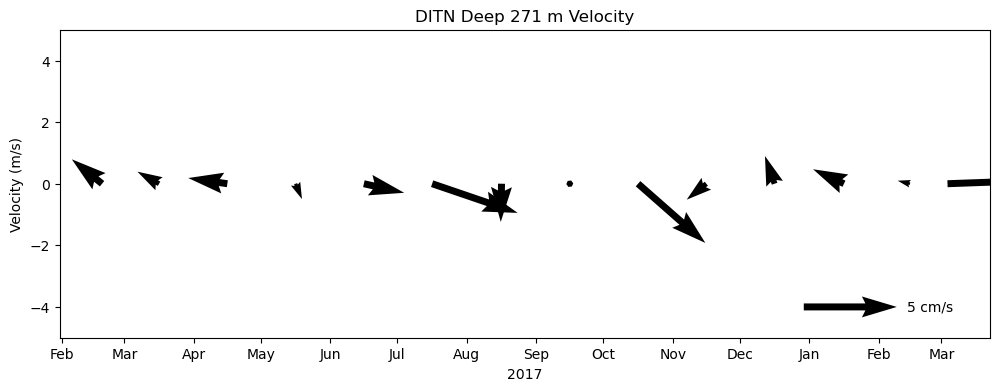

In [240]:
ds = DITN_2017_vel_bot
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12,4))
q = plt.quiver(
    ds.time.resample(time='M').mean().values,np.zeros_like(ds.time.resample(time='M').mean().values, dtype=float),
    ds.u.resample(time='M').mean(),
    ds.v.resample(time='M').mean(),
    scale=50
)
plt.quiverkey(q, X=0.90, Y=0.1, U=5, label='5 cm/s', labelpos='E')

plt.title('DITN Deep 271 m Velocity')
plt.ylabel('Velocity (m/s)')
plt.ylim(-5,5)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Show year once at the left
ax.set_xlabel('2017')


### DITD 

In [32]:
# load in all datasets for DITD mooring 
paths = glob.glob("//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD/*.nc")

In [33]:
paths

['//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121613.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121614.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121615.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121616.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121617.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121618.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121619.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121620.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121621.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121622.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121623.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121624.nc']

In [34]:
paths[0]

'//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121613.nc'

In [35]:
# create a list to hold datasets 
ds_list = []
for path in paths:
    ds = xr.open_dataset(path)
    ds_list.append(ds)

In [36]:
for i in range(len(ds_list)):
    print(ds_list[i].attrs['description'] + ', depth= ' + ds_list[i].z.values.astype(str))
# print(ds_list[1].attrs['description'] + ', depth= ' + ds_list[1].z.values.astype(str))

['Mooring DITD 1702 AQD, depth= 1239']
['Mooring DITD 1702 SBE37SM, depth= 1225']
['Mooring DITD 1803 AQD, depth= 1145' 'Mooring DITD 1803 AQD, depth= 1244']
['Mooring DITD 1803 SBE37SM, depth= 1122'
 'Mooring DITD 1803 SBE37SM, depth= 1218']
['Mooring DITD 1901 AQD, depth= 1221']
['Mooring DITD 1901 SBE37SM, depth= 1219']
['Mooring DITD 2003 AQD, depth= 1213']
['Mooring DITD 2003 SBE37SM, depth= 1218']
['Mooring DITD 2211 AQD, depth= 1204']
['Mooring DITD 2211 SBE37SM, depth= 1205']
['Mooring DITD 2401 AQD, depth= 1214']
['Mooring DITD 2401 SBE37SM, depth= 1206']


In [43]:
DITD_2017_vel_bot = ds_list[0].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2757,'lon':164.0673})
DITD_2017_ctd_bot = ds_list[1].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2757,'lon':164.0673})
DITD_2019_vel_bot = ds_list[4].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2766,'lon':164.0700})
DITD_2019_ctd_bot = ds_list[5].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2766,'lon':164.0700})
DITD_2020_vel_bot = ds_list[6].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2780,'lon':164.0603})
DITD_2020_ctd_bot = ds_list[7].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2780,'lon':164.0603})
DITD_2022_vel_bot = ds_list[8].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2778,'lon':164.0607})
DITD_2022_ctd_bot = ds_list[9].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2778,'lon':164.0607})
DITD_2024_vel_bot = ds_list[10].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2777,'lon':164.0602})
DITD_2024_ctd_bot = ds_list[11].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2777,'lon':164.0602})
# seperate dataset 1803 velocity and sbe into top and bottom components 
DITD_2018_vel_top = ds_list[2].sel(z=1145).rename({'DateTime':'time'}).assign_coords({'lat':-75.2773,'lon':164.071}) # bottom velocity
DITD_2018_vel_bot = ds_list[2].sel(z=1244).rename({'DateTime':'time'}).assign_coords({'lat':-75.2773,'lon':164.071}) # top velocity

DITD_2018_ctd_top = ds_list[3].sel(z=1122).rename({'DateTime':'time'}).assign_coords({'lat':-75.2773,'lon':164.071})  # bottom sbe
DITD_2018_ctd_bot = ds_list[3].sel(z=1218).rename({'DateTime':'time'}).assign_coords({'lat':-75.2773,'lon':164.071})  # top sbe

In [44]:
DITD_datasets = [
    DITD_2017_vel_bot,
    DITD_2017_ctd_bot,
    DITD_2019_vel_bot,
    DITD_2019_ctd_bot,
    DITD_2020_vel_bot,
    DITD_2020_ctd_bot,
    DITD_2022_vel_bot,
    DITD_2022_ctd_bot,
    DITD_2024_vel_bot,
    DITD_2024_ctd_bot,
    DITD_2018_vel_top,
    DITD_2018_vel_bot,
    DITD_2018_ctd_top,
    DITD_2018_ctd_bot,
]

dataset_names = [
    'DITD_2017_vel_bot',
    'DITD_2017_ctd_bot',
    'DITD_2019_vel_bot',
    'DITD_2019_ctd_bot',
    'DITD_2020_vel_bot',
    'DITD_2020_ctd_bot',
    'DITD_2022_vel_bot',
    'DITD_2022_ctd_bot',
    'DITD_2024_vel_bot',
    'DITD_2024_ctd_bot',
    'DITD_2018_vel_top',
    'DITD_2018_vel_bot',
    'DITD_2018_ctd_top',
    'DITD_2018_ctd_bot',
]

In [45]:
for i in range(len(DITD_datasets)):
    DITD_datasets[i] = rename_vars_if_exist(DITD_datasets[i], rename_map)
    DITD_datasets[i] = Add_U_V_if_missing(DITD_datasets[i])

In [46]:
for v, attrs in META_DATA.items():
    for i in range(len(DITD_datasets)):
        if v in DITD_datasets[i]:
            DITD_datasets[i][v].attrs.update(attrs)

In [47]:
DITD_datasets[10]

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 43002)
Coordinates:
  * time     (time) datetime64[ns] 344kB 2018-03-10T16:10:00 ... 2019-01-03T0...
    z        int64 8B 1145
    lat      float64 8B -75.28
    lon      float64 8B 164.1
Data variables: (12/15)
    dir      (time) float64 344kB ...
    speed    (time) float64 344kB ...
    temp     (time) float64 344kB ...
    pres     (time) float64 344kB ...
    hdgt     (time) float64 344kB ...
    pitch    (time) float64 344kB ...
    ...       ...
    w        (time) float64 344kB ...
    volt     (time) float64 344kB ...
    amp1     (time) float64 344kB ...
    amp2     (time) float64 344kB ...
    amp3     (time) float64 344kB ...
    depth    (time) float64 344kB ...
Attributes:
    description:  Mooring DITD 1803 AQD

In [48]:
# for i in range(len(DITD_datasets)):
#     DITD_datasets[i].to_netcdf(path='//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD/'+dataset_names[i]+'.nc')